In [1]:
import torch
import numpy as np
import scipy.sparse as sp

from torch import nn
from torch import optim
import torch.nn.functional as F

from implicit.Block import LayerBlock
from implicit.Model import SequentialBlockModel
from implicit.Ops import FlattenOpL
from utils import transpose, mnist_load, cifar_load, get_valid_accuracy, get_robust_accuracy, Logger

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
        self.relu = torch.nn.ReLU()
        self.avgpool = torch.nn.AvgPool2d(2)

        self.flatten = FlattenOpL()
        self.block1 = LayerBlock([self.conv1], [self.relu])
        self.block2 = LayerBlock([self.avgpool, self.conv2], [self.relu])
        self.block3 = LayerBlock([self.avgpool, self.flatten, self.fc1], [self.relu])
        self.block4 = LayerBlock([self.fc2], [self.relu])
        self.block5 = LayerBlock([self.fc3], [])
        self.model = SequentialBlockModel([self.block1, self.block2, self.block3, self.block4, self.block5], populate_C=True)

    def forward(self, xs):
        xs = xs.reshape((-1, 1, 28, 28))
        xs = torch.nn.functional.pad(xs, (2, 2, 2, 2), 'constant', 0)
        return self.model(xs)

In [3]:
bs = 100
device = torch.device("cpu")
train_ds, train_dl, valid_ds, valid_dl = mnist_load(bs)
loss_fn = F.cross_entropy
model = LeNet5()
model.to(device)
l = Logger.load_profile('/home/beeperman/Projects/ImplicitLayers/logs/LeNet5_Implicit_Construction_2019-11-20_14:32:45')
model.load_state_dict(l.data_dict[l.BEST], strict=False)
res = get_valid_accuracy(model, loss_fn, valid_dl, device)
print(res)

INFO: <function FlattenOpL.__init__.<locals>.<lambda> at 0x7f0f6049b320> is not a torch Module
(tensor(0.0411, grad_fn=<NllLossBackward>), 0.9901)


In [4]:
def implicit_forward(xs):
    xs = xs.reshape((-1, 1, 28, 28))
    xs = torch.nn.functional.pad(xs, (2, 2, 2, 2), 'constant', 0)
    A, B, C, D, phi = model.model.getImplicitModel(xs[0:1])
    i = SequentialBlockModel.implicit_forward(sp.csr_matrix(A), B, C, D, phi, xs)
    return i

model.eval()
res = get_valid_accuracy(implicit_forward, loss_fn, valid_dl, device)
print(res)

(tensor(0.0411, dtype=torch.float64), 0.9901)


In [5]:
for xs, ys in valid_dl:
    xs = xs.reshape((-1, 1, 28, 28))
    xs = torch.nn.functional.pad(xs, (2, 2, 2, 2), 'constant', 0)
    A,B,C,D,phi = model.model.getImplicitModel(xs[0:1, :])
    break

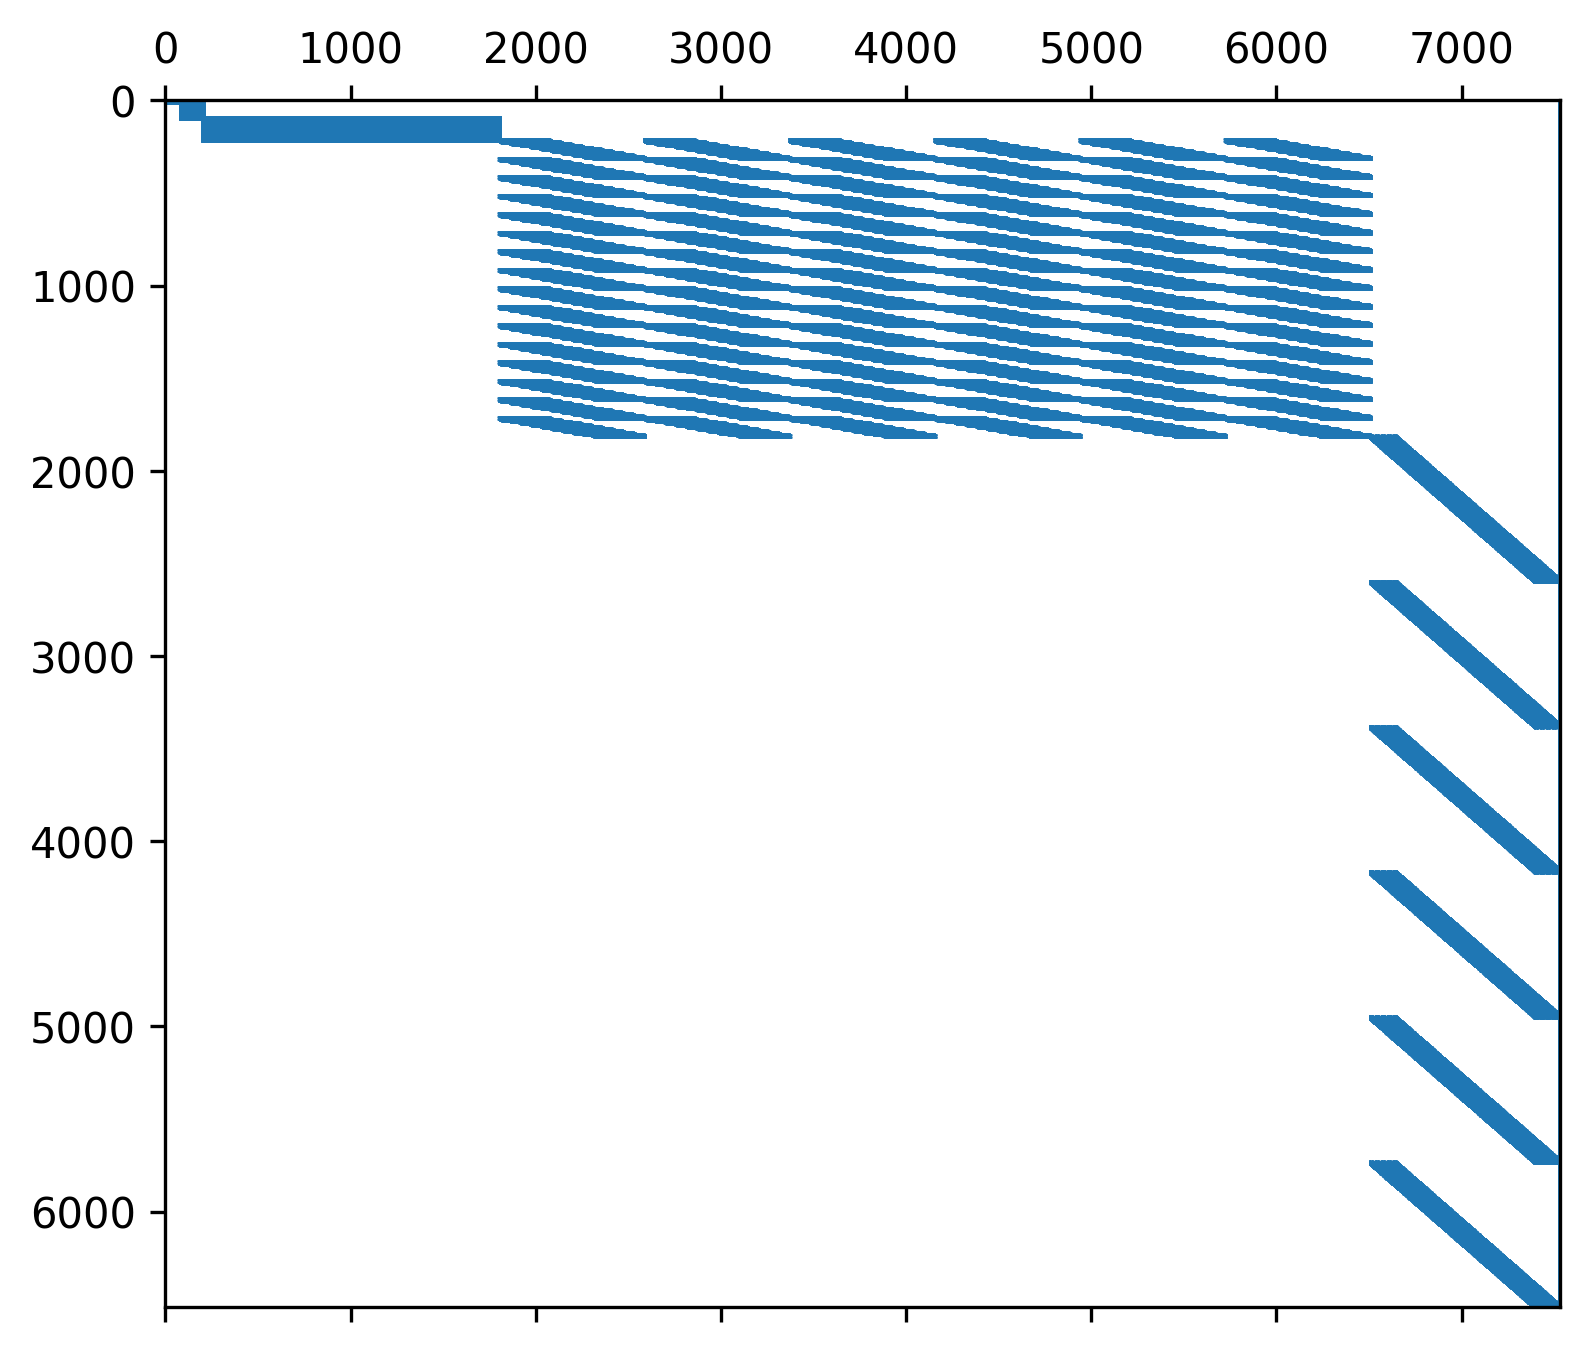

In [6]:
plt.figure(figsize=(6,6), dpi=300)
plt.spy(sp.bmat([[C, D], [A, B]]), markersize=0.01)
plt.show()

In [7]:
class LeNet5CIFAR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
        self.relu = torch.nn.ReLU()
        self.avgpool = torch.nn.AvgPool2d(2)

        self.flatten = FlattenOpL()
        self.block1 = LayerBlock([self.conv1], [self.relu])
        self.block2 = LayerBlock([self.avgpool, self.conv2], [self.relu])
        self.block3 = LayerBlock([self.avgpool, self.flatten, self.fc1], [self.relu])
        self.block4 = LayerBlock([self.fc2], [self.relu])
        self.block5 = LayerBlock([self.fc3], [])
        self.model = SequentialBlockModel([self.block1, self.block2, self.block3, self.block4, self.block5], populate_C=True)

    def forward(self, xs):
        xs = xs.reshape((-1,3,32,32))
        return self.model(xs)

In [8]:
bs = 100
device = torch.device("cpu")
train_ds, train_dl, valid_ds, valid_dl = cifar_load(bs)
loss_fn = F.cross_entropy
model = LeNet5CIFAR()
model.to(device)
l = Logger.load_profile('/home/beeperman/Projects/ImplicitLayers/logs/CIFAR10_LeNet5_Implicit_Construction_2019-11-24_13:20:53')
model.load_state_dict(l.data_dict[l.BEST], strict=False)
res = get_valid_accuracy(model, loss_fn, valid_dl, device)
print(res)

Files already downloaded and verified
INFO: <function FlattenOpL.__init__.<locals>.<lambda> at 0x7f21ef1a49e0> is not a torch Module
(tensor(1.1433, grad_fn=<NllLossBackward>), 0.613)


In [9]:
def implicit_forward(xs):
    xs = xs.reshape((-1,3,32,32))
    A, B, C, D, phi = model.model.getImplicitModel(xs[0:1])
    i = SequentialBlockModel.implicit_forward(sp.csr_matrix(A), B, C, D, phi, xs)
    return i

model.eval()
res = get_valid_accuracy(implicit_forward, loss_fn, valid_dl, device)
print(res)

(tensor(1.1433, dtype=torch.float64), 0.613)


In [10]:
for xs, ys in valid_dl:
    xs = xs.reshape((-1,3,32,32))
    A,B,C,D,phi = model.model.getImplicitModel(xs[0:1, :])
    break

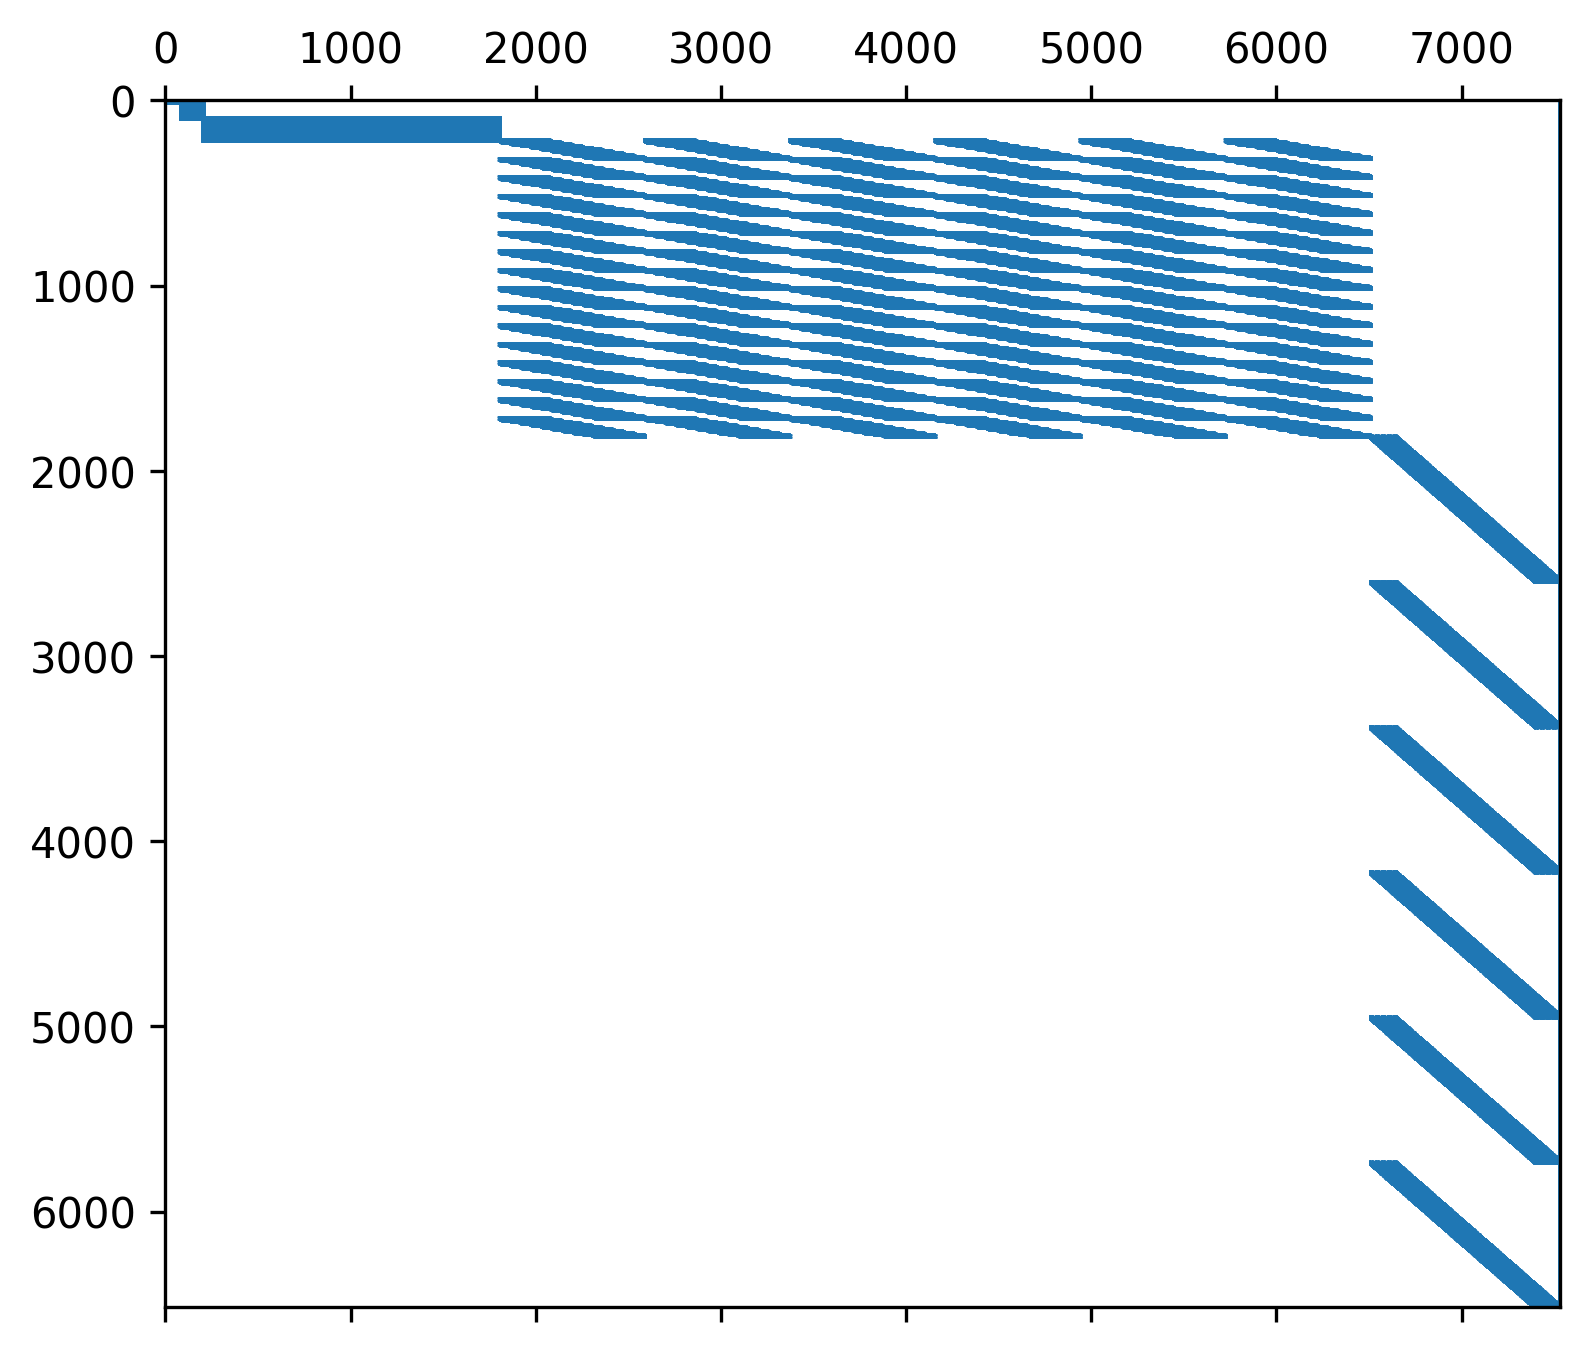

In [6]:
plt.figure(figsize=(6,6), dpi=300)
plt.spy(sp.bmat([[C, D], [A, B]]), markersize=0.01)
plt.show()

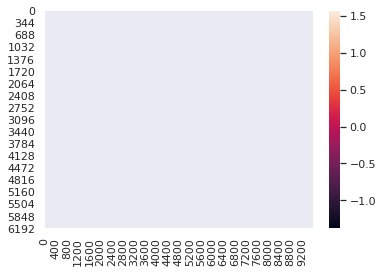

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()


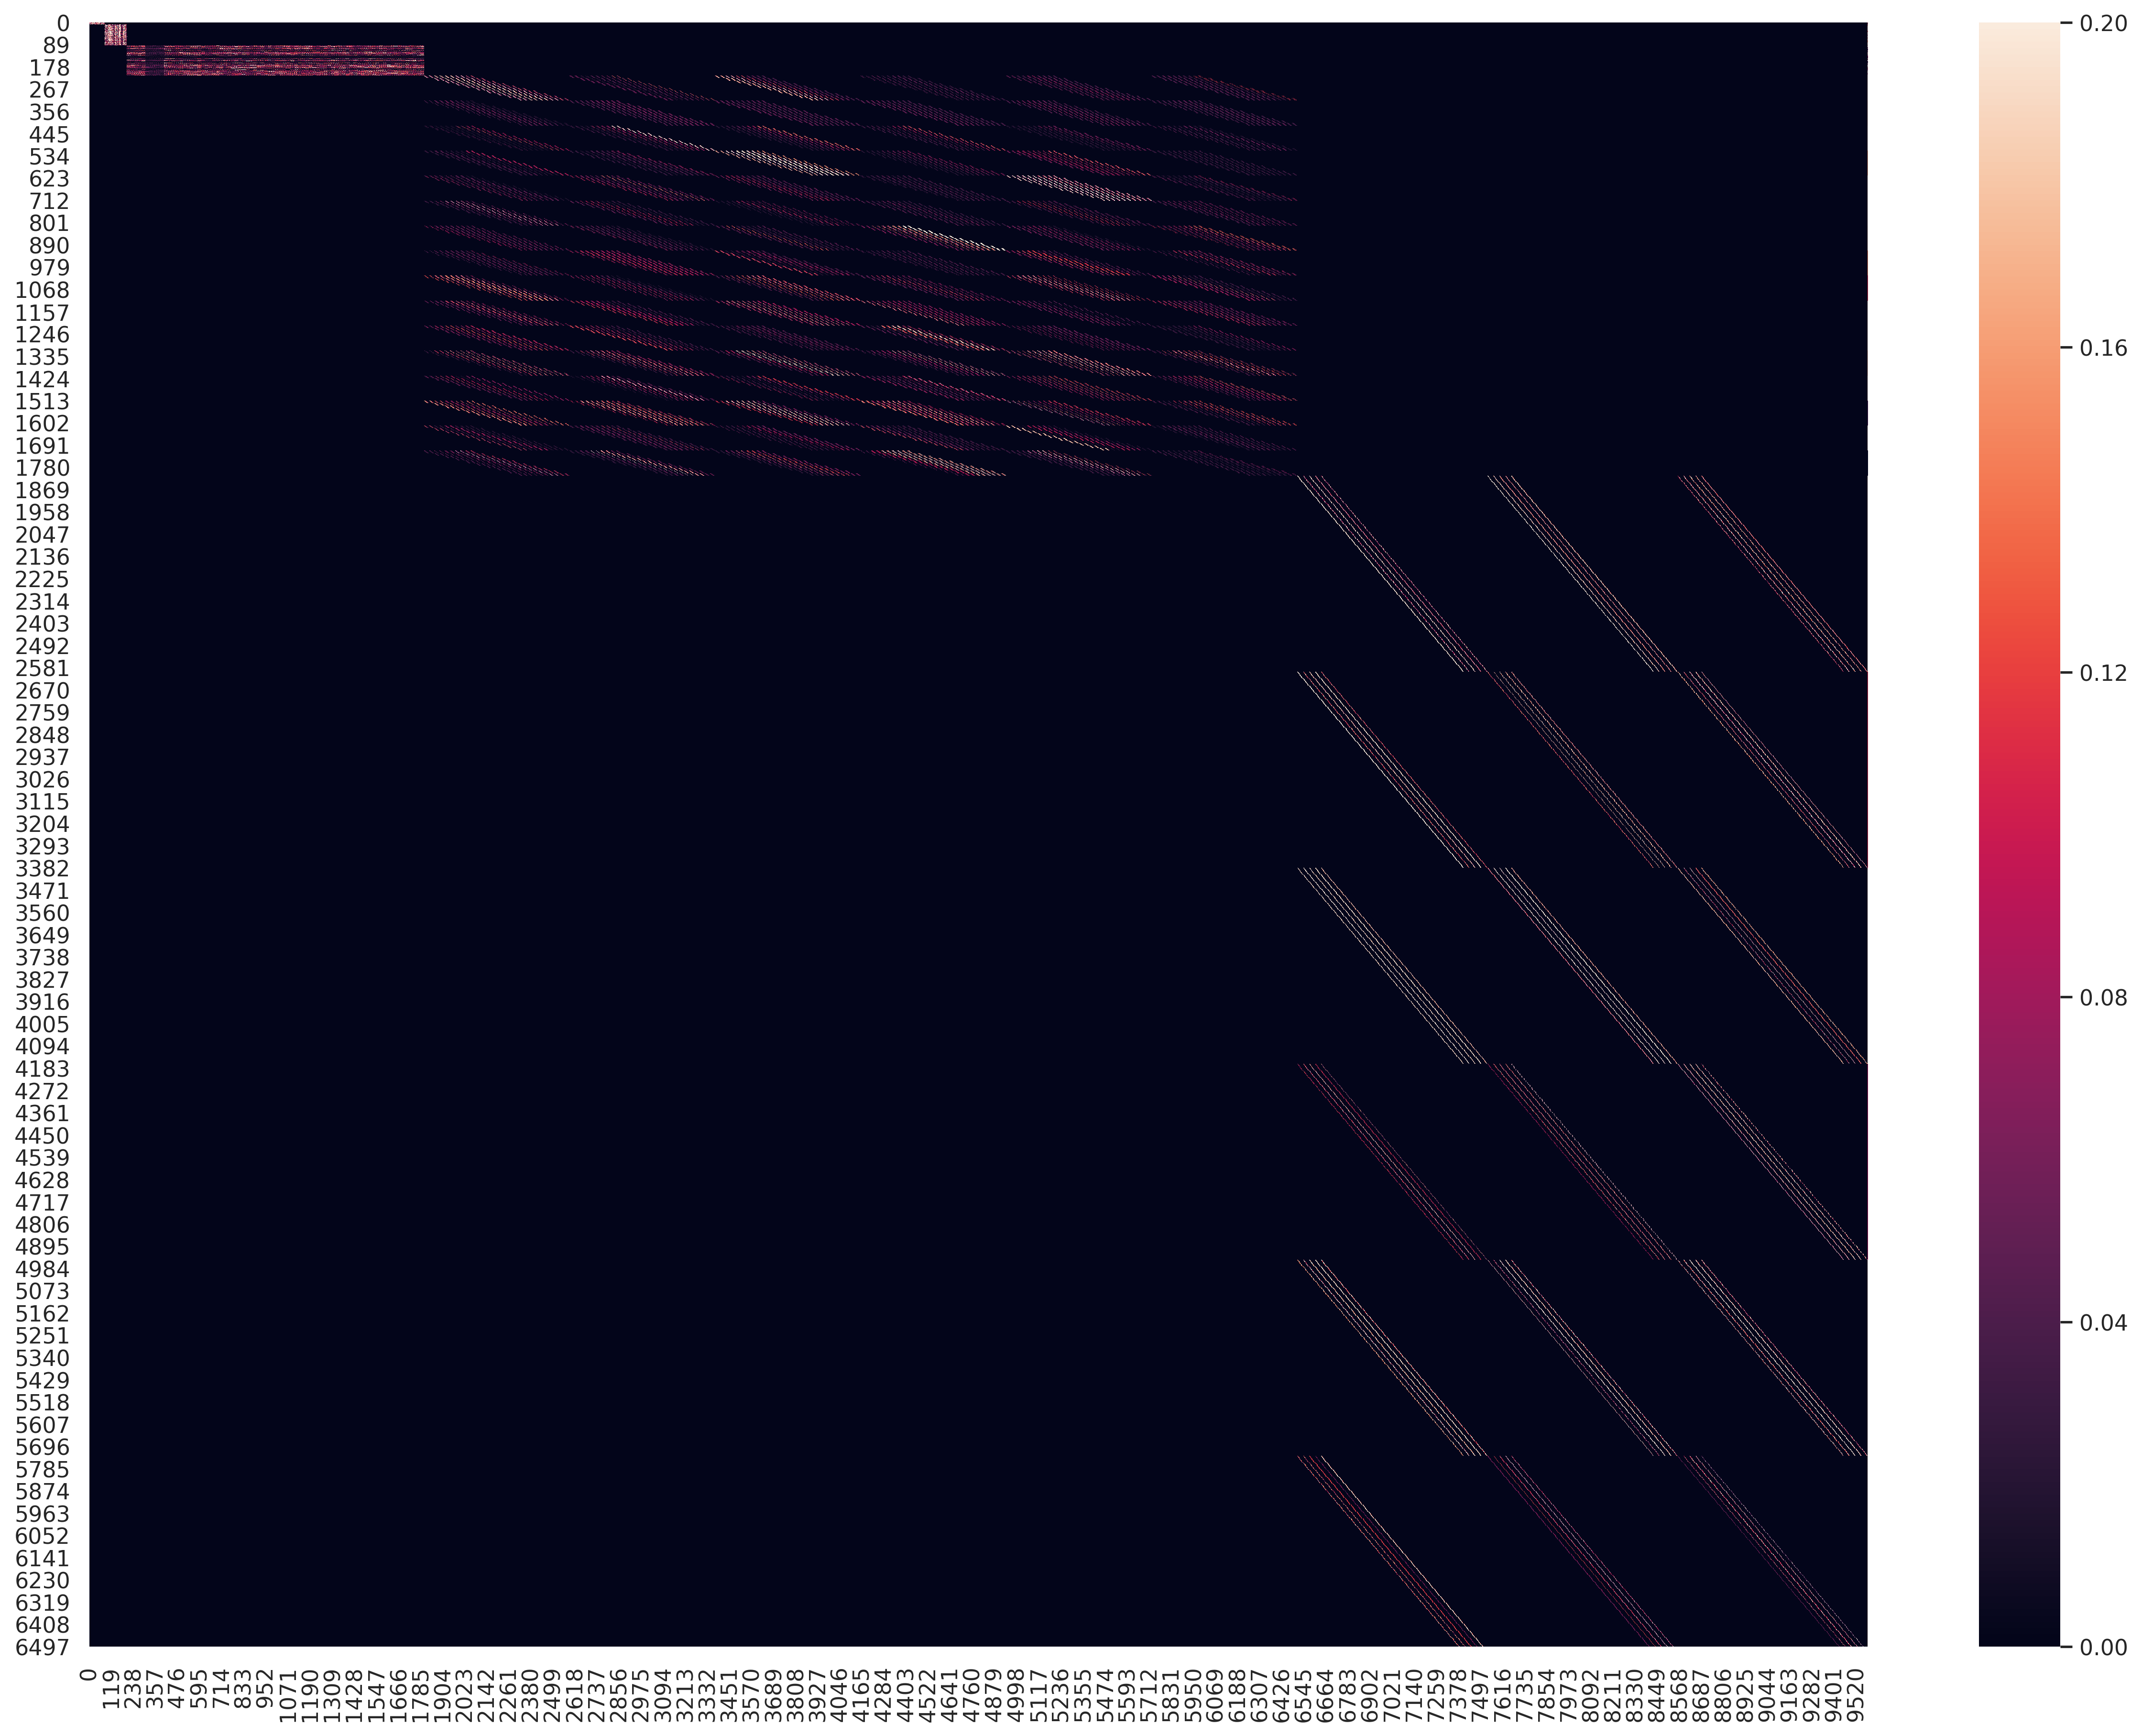

In [22]:
plt.figure(figsize=(20,15), dpi=300)
sns.heatmap(np.abs(sp.bmat([[C, D], [A, B]]).todense()), vmax=0.2)

In [19]:
a = np.array([[1,2]]).sum(axis=-1)
a

array([3])